In [ ]:
#This cell is tagged "parameters"
startTime = "2021-04-06 00:00:00.000"
endTime   = "2021-04-10 23:59:00.000"
featureParameters = ['FQSTR_013_VOL_QT241.POSST', 'FQSTR_013_VOL_QT242.POSST', 'FQSTR_013_VOL_QT243.POSST','FQSTR_013_VOL_QT244.POSST']


## This notebook will display Water Counter information for the EN-CV group
### Sub header
by Soren Poulsen (EN-CV-CL)

This notebook is ...

List of water counters:
* Main Water flow *xxxxxx* which provides water to ... 
    * Building ...
    * Building ...
    
* Main Water Flow *yyyyyy* which provides water to ...
    * Building ...
    * Building ...

More info ...
FQSTR_013_VOL_QT241.POSST
FQSTR_013_VOL_QT242.POSST
FQSTR_013_VOL_QT243.POSST
FQSTR_013_VOL_QT244.POSST


TBCompleted


# Connect to the cluster (NXCals)

In [63]:
# reference to NXCALS API - http://nxcals-docs.web.cern.ch/0.1.164/user-guide/library-reference/
# source the nxcals python libs
from cern.nxcals.pyquery.builders import *
from pyspark.sql import DataFrame

from pyspark.sql.functions import *
import ipywidgets as widgets

#print(spark.version)

# Read the NxCALS variable into spark dataframe

In [64]:
print('Select one or multiple counters (use CTRL + mouse select for multiple selection)')
wCounter = widgets.SelectMultiple(
    options=['FQSTR_013_VOL_QT241.POSST', 'FQSTR_013_VOL_QT242.POSST', 'FQSTR_013_VOL_QT243.POSST','FQSTR_013_VOL_QT244.POSST'],
    value=['FQSTR_013_VOL_QT241.POSST'],
    #rows=10,
    description='Counter:',
    disabled=False
)

#PENDING: Check and remove the current date from the calendar!!

wDate = widgets.DatePicker(description='Date:',disabled=False)
wDate.value = datetime.date(datetime.today())
display(wCounter)
display(wDate)

Select one or multiple counters (use CTRL + mouse select for multiple selection)


SelectMultiple(description='Counter:', index=(0,), options=('FQSTR_013_VOL_QT241.POSST', 'FQSTR_013_VOL_QT242.…

DatePicker(value=datetime.date(2021, 3, 9), description='Date:')

In [65]:
display(wCounter.value)

selectedDate = wDate.value
print(selectedDate)

('FQSTR_013_VOL_QT241.POSST',
 'FQSTR_013_VOL_QT242.POSST',
 'FQSTR_013_VOL_QT243.POSST')

2021-02-25


In [66]:
selectedDate = wDate.value
selectedDate = datetime.combine(selectedDate, datetime.min.time())
print(selectedDate)

2021-02-25 00:00:00


In [67]:
# Build the query and load data into spark dataframe
# Predefined time period is 1 day

ModStartTime = selectedDate
ModEndTime = selectedDate + timedelta(days = 1)

print(ModStartTime)
print(ModEndTime)

listCounters = wCounter.value
print(listCounters)

2021-02-25 00:00:00
2021-02-26 00:00:00
('FQSTR_013_VOL_QT241.POSST', 'FQSTR_013_VOL_QT242.POSST', 'FQSTR_013_VOL_QT243.POSST')


In [68]:
dfList = []
for i in range(len(listCounters)):
    dfList.append(KeyValuesQuery.builder(spark).system("WINCCOA").startTime(ModStartTime).endTime(ModEndTime).entity().keyValueLike("variable_name", listCounters[i]).buildDataset())
    
#print(dfList)
#type(dfList[0])
#dfList[0].printSchema()
#dfList[0].show(5,False)


In [69]:
#sorting by date
for i in range(len(dfList)):
    dfList[i] = dfList[i].select("variable_name", "value", "nxcals_entity_id", from_unixtime(dfList[i].timestamp/1000000000,format='yyyy-MM-dd HH:mm:ss').alias('date')).orderBy("date")
    #dfList[i].show(5,False)


# Data visualization

In [70]:
import pandas as pd

#creating list of pandas elements
pandas_dfList = []

for i in range(len(dfList)):
    pandas_dfList.append(dfList[i].select('variable_name', 'value', 'date').orderBy("date").toPandas()) 
    pandas_dfList[i]["date"] = pd.to_datetime(pandas_dfList[i]["date"])


In [71]:
#%%capture out

minList = [] #list containing the minimum value of every counter
maxList = [] #list containing the maximum value of every counter
totalList = [] #list containing the total value of every counter (subtraction max - min)

#print(pandas_dfList[i].variable_name)

for i in range(len(pandas_dfList)):
    minList.append(pandas_dfList[i]['value'].min() / 1000)
    maxList.append(pandas_dfList[i]['value'].max() / 1000)
    #taking only 3 decimals
    tempTotal="{:.3f}".format((maxList[i] - minList[i]))
    tempTotal=float(tempTotal)
    totalList.append(tempTotal)
    #print(pandas_dfList[i].variable_name)
    print(listCounters[i])
    print('value at '+str(ModStartTime)+': ' +str(minList[i])+' m3')
    print('value at '+str(ModEndTime)+': ' +str(maxList[i])+' m3')
    print('total:'+str(totalList[i])+' m3')
    print(' ')

FQSTR_013_VOL_QT241.POSST
value at 2021-02-25 00:00:00: 2455.7 m3
value at 2021-02-26 00:00:00: 2483.8 m3
total:28.1 m3
 
FQSTR_013_VOL_QT242.POSST
value at 2021-02-25 00:00:00: 43.647 m3
value at 2021-02-26 00:00:00: 44.089 m3
total:0.442 m3
 
FQSTR_013_VOL_QT243.POSST
value at 2021-02-25 00:00:00: 3.1 m3
value at 2021-02-26 00:00:00: 4.2 m3
total:1.1 m3
 


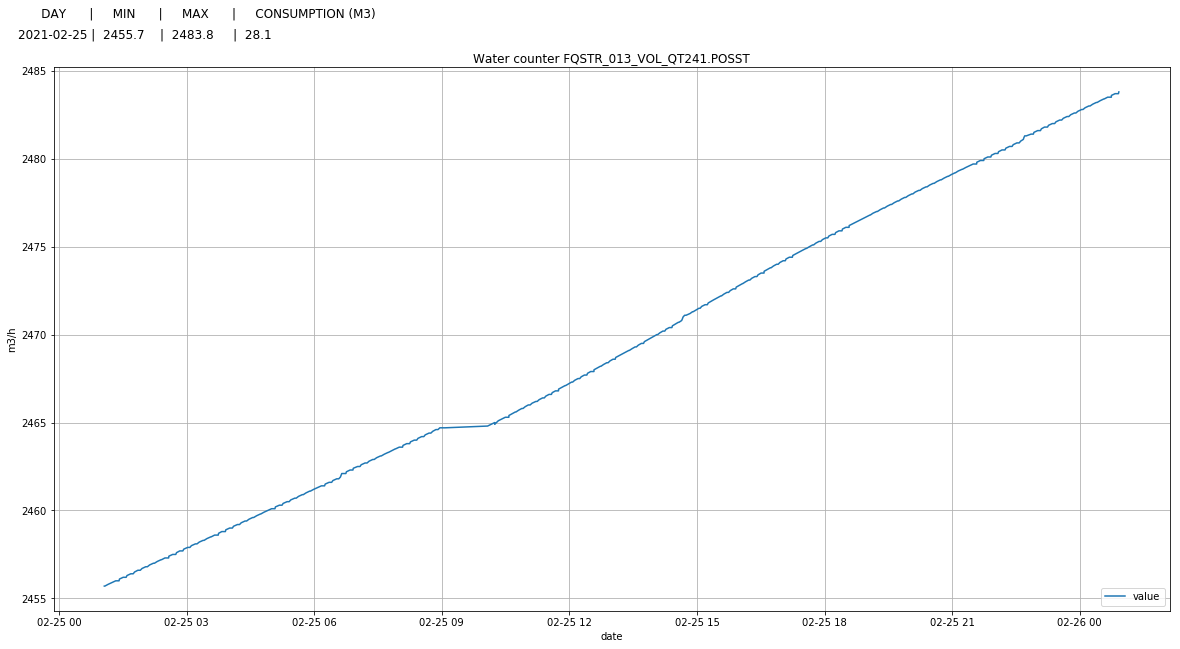

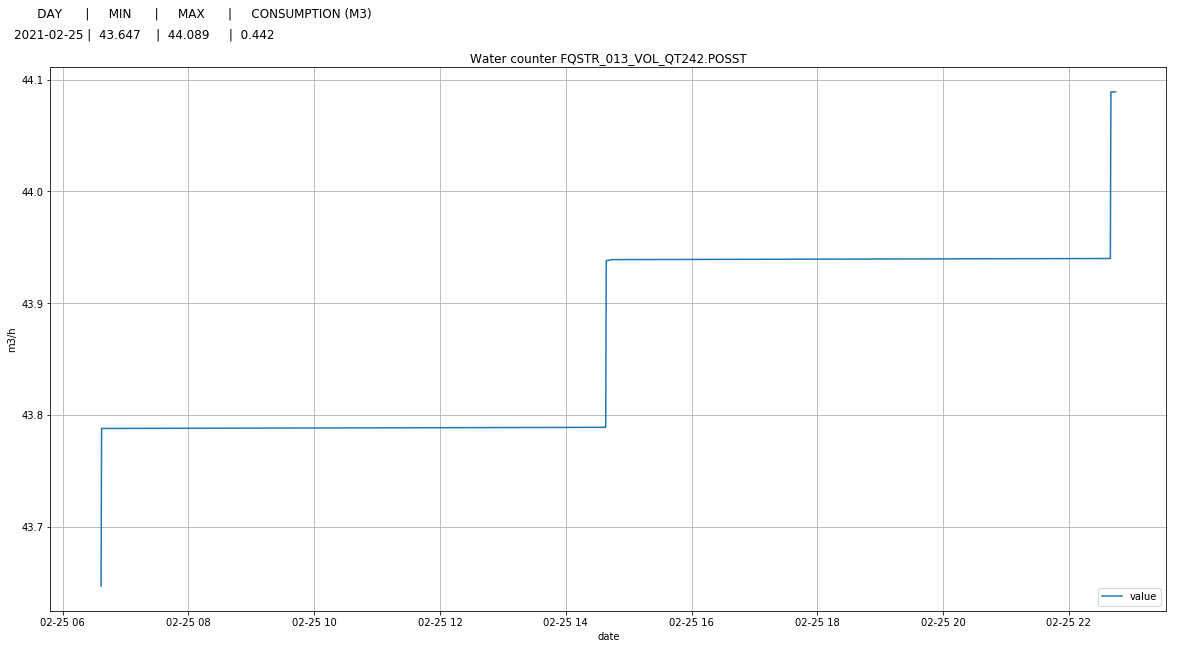

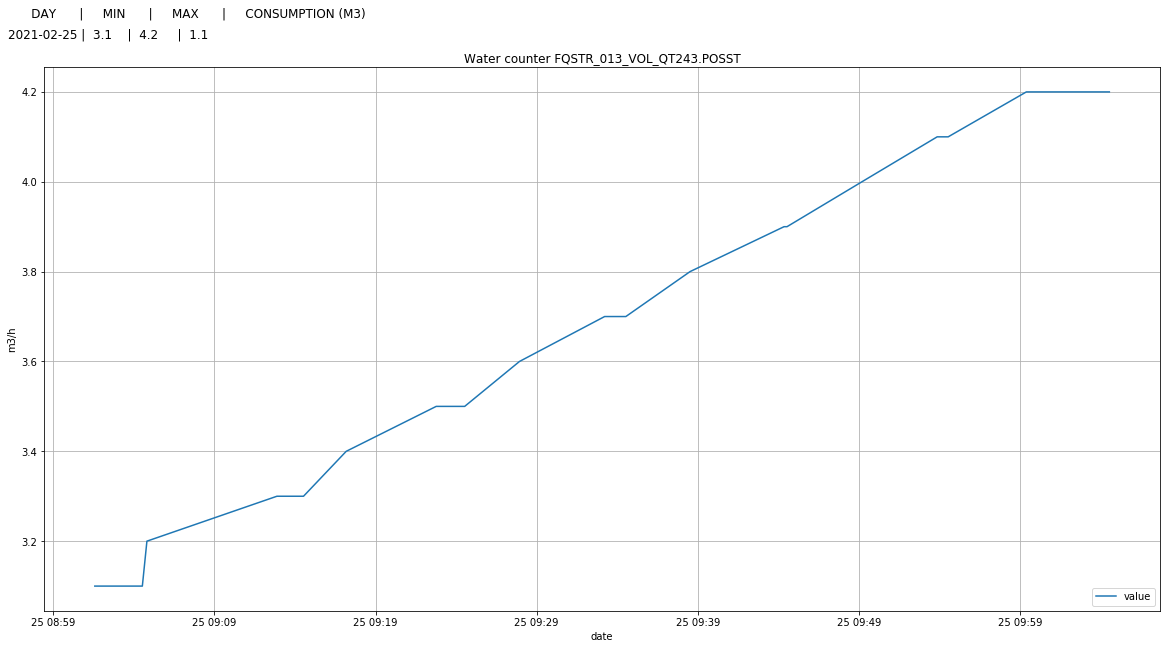

In [72]:
import matplotlib.pyplot as plt
#%matplotlib notebook

figuresList = []

for i in range(len(pandas_dfList)):
    fig = plt.figure(figsize=(20, 10))
    #plt.plot([0,1], [0,1], 'k--', color='orange')
    plt.plot(pandas_dfList[i].date, pandas_dfList[i].value/1000)

    plt.xlabel('date')
    plt.ylabel('m3/h')
    plt.title('Water counter '+ listCounters[i])
    plt.legend(loc='lower right')

    txt = '      DAY      |     MIN      |     MAX      |     CONSUMPTION (M3) '
    plt.text(0.1,0.95,txt, transform=fig.transFigure, size=12)
    
    txt = str(wDate.value) +' |  '+ str(minList[i]) +'    |  '+ str(maxList[i]) +'     |  '+ str(totalList[i])
    plt.text(0.1,0.92,txt, transform=fig.transFigure, size=12)
   
    plt.grid()
    #plt.show()

    #plt.close()
    figuresList.append(fig)

    #print(listCounters[i])
    #print('value at '+str(ModStartTime)+': ' +str(minList[i])+' m3')
    #print('value at '+str(ModEndTime)+': ' +str(maxList[i])+' m3')
    #print('total:'+str(totalList[i])+' m3')
    #print(' ')

#figuresList[0]

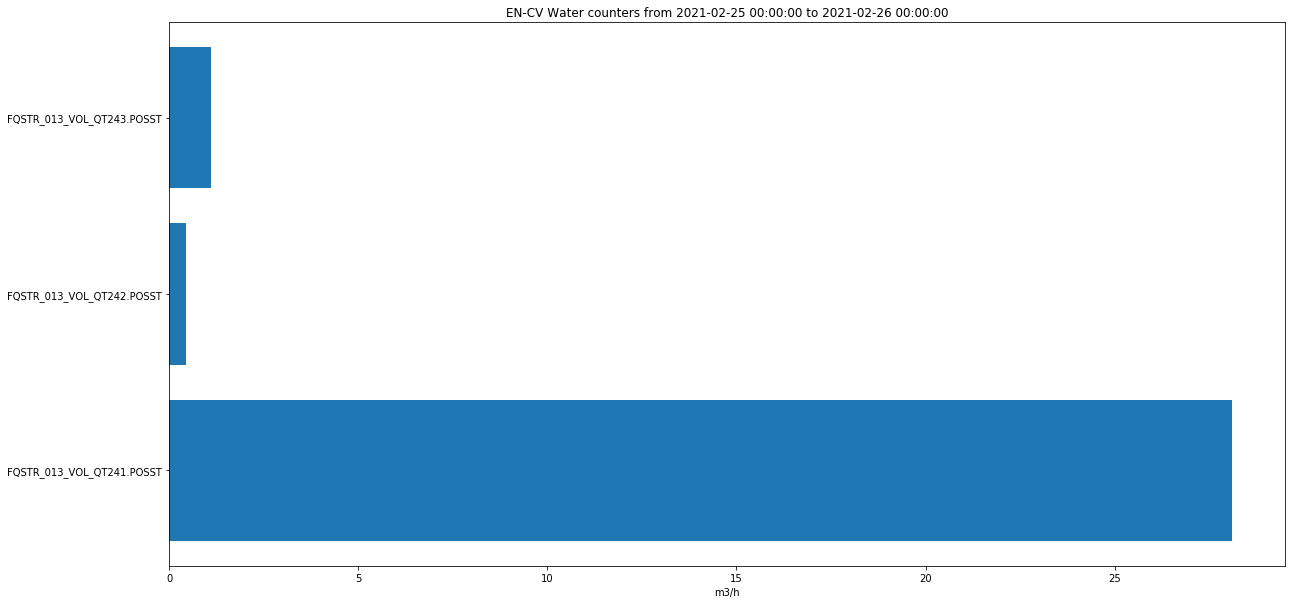

In [73]:
#(if numvars >= 2)
#PENDING to check num of vars, only makes sense for >= 2 variables 

fig2 = plt.figure(figsize=(20, 10))
#plt.plot([0,1], [0,1], 'k--', color='orange')
plt.barh(wCounter.value, totalList)

plt.xlabel("m3/h")
plt.title('EN-CV Water counters from '+ str(ModStartTime)+' to '+ str(ModEndTime))
#plt.xlabel('testxlabel')
figuresList.append(fig2)


# PDF generation

In [74]:
from matplotlib.backends.backend_pdf import PdfPages
pdfFileName="WaterCounters_TEST.pdf"

with PdfPages(pdfFileName) as pdf:
    for i in range(len(figuresList)):
        pdf.savefig(figuresList[i])    

#End %%capture out
#only for printing if '%%capture out' is active
#out.show()